# Продвинутое машинное обучение: ДЗ 1

## Часть I: О теореме Байеса

### Задание 1

Произошло убийство. На месте убийства найдена кровь, которая явно (будем считать, что с вероятностью 1) принадлежит настоящему убийце. Кровь принадлежит редкой группе, которая присутствует всего лишь у 1% населения. И так получилось, что у подсудимого как раз эта редкая группа крови!

Первым выходит прокурор и говорит: “Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен -- всего 1%; значит, с вероятностью 99% он виновен, предлагаю осудить”. В чём не прав прокурор? Укажите, какие вероятности он оценил, а какие должен был оценить.


Введем следующие события:
- событие A - у человека редкая группа крови;
- событие B - подсудимый виновен.
Тогда прокурор оценил следующие вероятности:

$$
P(A|\overline{B}) = 0.99 \\
P(B) = 0.1
$$
Должен был оценить следующую вероятность
$$
P(B|A) = \frac{P(B)P(A|B}{P(A)}
$$

### Задание 2

Затем выходит адвокат, объясняет ошибки прокурора и берёт слово сам: “В городе живёт миллион человек. Это значит, что примерно у 10000 из них такая группа крови. Значит, всё, что говорит нам эта кровь -- это то, что подсудимый совершил убийство с вероятностью 0.01%. Получается, что это свидетельство не просто не является строгим доказательством, а и вовсе даёт нам ничтожно малую вероятность того, что мой подзащитный виновен, так что предлагаю исключить его из материалов дела”. В чём не прав адвокат? Какие вероятности он оценил, а какие должен был оценить?


Адвокат оценил 
$$
P(вероятность\,редкой\,группы\,крови\,у\,случайного\,человека) = 0.01
$$

Рассуждение верное, но при этом адвокат не учитывает, что человек уже подозреваемый.

На самом деле адвокат должен был оценить:
$$
P(\overline{B}|A) = \frac{P(\overline{B})P(A|\overline{B})}{P(A)}
$$

### Задание 3

Вернёмся к тесту на коронавирус из лекции. Напомню, что коронавирусом по нашему предположению болеет 1% населения, а тест имеет вероятность ошибки 5% в обе стороны. Мы видели, что в результате человек с положительным тестом имеет апостериорную вероятность оказаться больным всего лишь около 16%. Врачи решили, что терпеть это никак нельзя; они готовы провести срочное исследование и улучшить качество теста на коронавирус. Но сил и денег хватит только для того, чтобы сократить один тип ошибок, т.е. уменьшить или только число false positives (когда тест выдаёт позитивный результат у здорового человека), или только число false negatives (когда тест выдаёт отрицательный результат у больного). Помогите медикам: постройте зависимости апостериорных вероятностей болезни после положительного и отрицательного теста от обоих видов ошибок (например, в виде графиков), сделайте выводы и дайте рекомендации врачам -- на чём лучше сосредоточиться?

Введем некоторые обозначения:
- A - положительный тест
- B - болен
- P(A) - FP
- P(B) - FN

$$
P(B|A) = \frac{P(B)P(A|B)}{P(A|B)P(B) + P(A|\overline{B})P(\overline{B})}
$$
$$
P(B|\overline{A}) = \frac{P(\overline{A})P(B)}{P(\overline{A}|B)P(B) + P(\overline{A}|\overline{B})P(\overline{B})}
$$

In [23]:
import datetime

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

%matplotlib inline

In [80]:
def get_posterior_prob(fp, fn, test=True):
    tp = 1 - fn
    tn = 1 - fp
    if test:
        return (1 - fn) * 0.01 / ((1 - fn) * 0.01 + fp * 0.99)
    return fn * 0.01 / (fn * 0.01 + (1 - fp) * 0.99)

In [81]:
errors = np.linspace(0.0001, 0.05, 20)

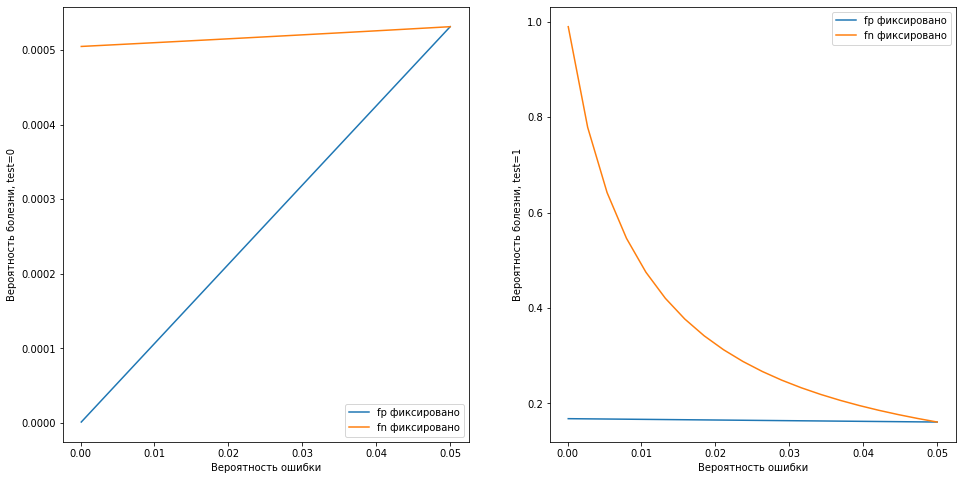

In [82]:
error_types = ['fn', 'fp']
subplot_id = 1
plt.figure(figsize=(16, 8))
for test in [0, 1]:
    plt.subplot(1, 2, subplot_id)
    subplot_id += 1
    plt.xlabel('Вероятность ошибки')
    plt.ylabel(f'Вероятность болезни, test={test}')
    for i, _ in enumerate(error_types):
        if error_types[i] == 'fn':
            probs = get_posterior_prob(0.05, errors, test)
        else:
            probs = get_posterior_prob(errors, 0.05, test)
        label = f'{error_types[i ^ 1]} фиксировано'
        plt.plot(errors, probs, label=label)
        plt.legend()
        
plt.show();

Следовательно, оптимальным было бы оптимизировать FN

## Часть II: О линейной регрессии

In [4]:
!wget https://covid.ourworldindata.org/data/owid-covid-data.csv

--2021-02-24 21:08:44--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Распознаётся covid.ourworldindata.org (covid.ourworldindata.org)… 104.21.233.137, 104.21.233.138
Подключение к covid.ourworldindata.org (covid.ourworldindata.org)|104.21.233.137|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных [text/csv]
Сохранение в: «owid-covid-data.csv»

owid-covid-data.csv     [           <=>      ]  17,20M  7,51MB/s    за 2,3s    

2021-02-24 21:08:46 (7,51 MB/s) - «owid-covid-data.csv» сохранён [18040380]



In [99]:
df = pd.read_csv('owid-covid-data.csv')

In [100]:
df = df[df.location=='Russia']
df.date = pd.to_datetime(df.date)
df = df[df.date >= datetime.datetime(2020, 3, 3)]
df.loc[df.new_cases==0, 'new_cases'] = 1
df.index = df.date
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,
2020-03-03,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
2020-03-04,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
2020-03-05,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
2020-03-06,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
2020-03-07,RUS,Europe,Russia,2020-03-07,13.0,1.0,1.571,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824


In [101]:
train_size = 50
train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [102]:
print(f'Train size {train.shape[0]} \nTest size {test.shape[0]}')

Train size 50 
Test size 308


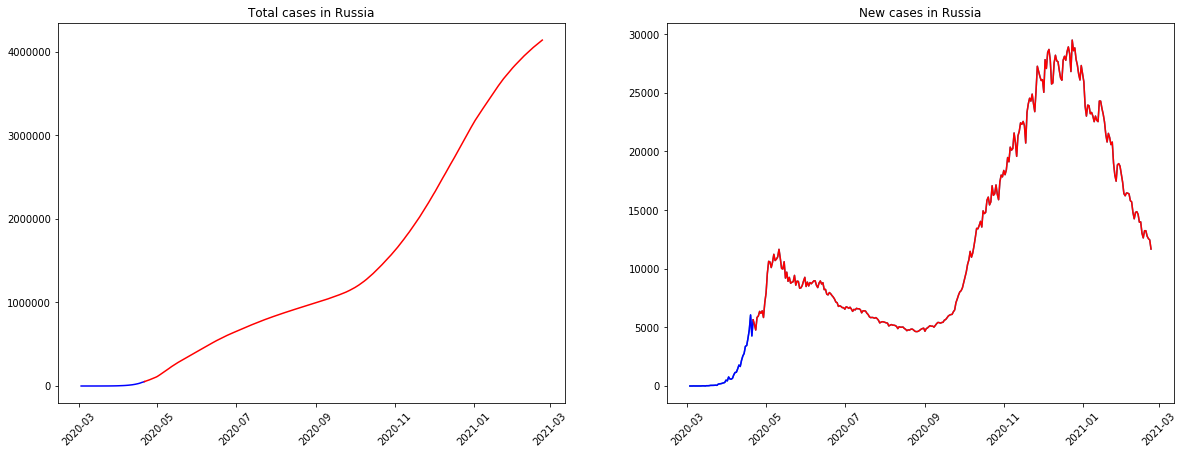

In [103]:
plt.subplots(1, 2, figsize=(20, 7))

plt.subplot(121)
plt.plot(df.iloc[:train_size].total_cases, color='blue')
plt.plot(df.iloc[train_size - 1:].total_cases, color='red')
plt.title('Total cases in Russia')
plt.xticks(rotation=45)

plt.subplot(122)
plt.plot(df.new_cases)
plt.plot(df.iloc[:train_size].new_cases, color='blue')
plt.plot(df.iloc[train_size - 1:].new_cases, color='red')
plt.title('New cases in Russia')
plt.xticks(rotation=45)
plt.show()

In [104]:
# Первые 50 дней с 1 по 50 - train
x_train = np.arange(1, train_size + 1)
# y1 - обозначим total cases, y2 - new cases

# Обучаем модели для log(y) = w_0 + w_1*x
log_total_train = np.log(train.total_cases.values)
totalcases_exp_model = LinearRegression(fit_intercept=True).fit(x_train[:, np.newaxis], log_total_train)

log_new_train = np.log(train.new_cases.values)
newcases_exp_model = LinearRegression(fit_intercept=True).fit(x_train[:, np.newaxis], log_new_train)

In [105]:
# Предсказания моделей:
x_test = np.arange(x_train[-1], x_train[-1] + len(test)) + 1

total_train_predict = totalcases_exp_model.predict(x_train[:, np.newaxis])
total_test_predict = totalcases_exp_model.predict(x_test[:, np.newaxis])

new_train_predict = newcases_exp_model.predict(x_train[:, np.newaxis])
new_test_predict = newcases_exp_model.predict(x_test[:, np.newaxis])

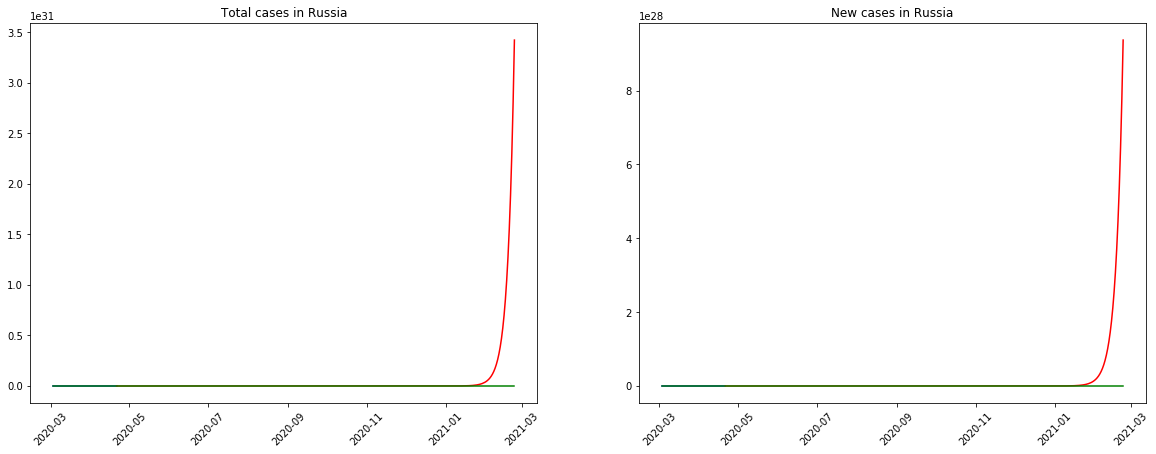

In [106]:
plt.subplots(1, 2, figsize=(20, 7))

plt.subplot(121)
plt.plot(df.iloc[:train_size].index, np.exp(total_train_predict), color='blue')
plt.plot(df.iloc[train_size - 1:].index, np.exp(np.hstack([[total_train_predict[-1]], total_test_predict])), color='red')
plt.plot(df.total_cases, color='green')
plt.title('Total cases in Russia')
plt.xticks(rotation=45)

plt.subplot(122)
plt.plot(df.iloc[:train_size].index, np.exp(new_train_predict), color='blue')
plt.plot(df.iloc[train_size - 1:].index, np.exp(np.hstack([[new_train_predict[-1]], new_test_predict])), color='red')
plt.plot(df.new_cases, color='green')
plt.title('New cases in Russia')
plt.xticks(rotation=45)

plt.show()

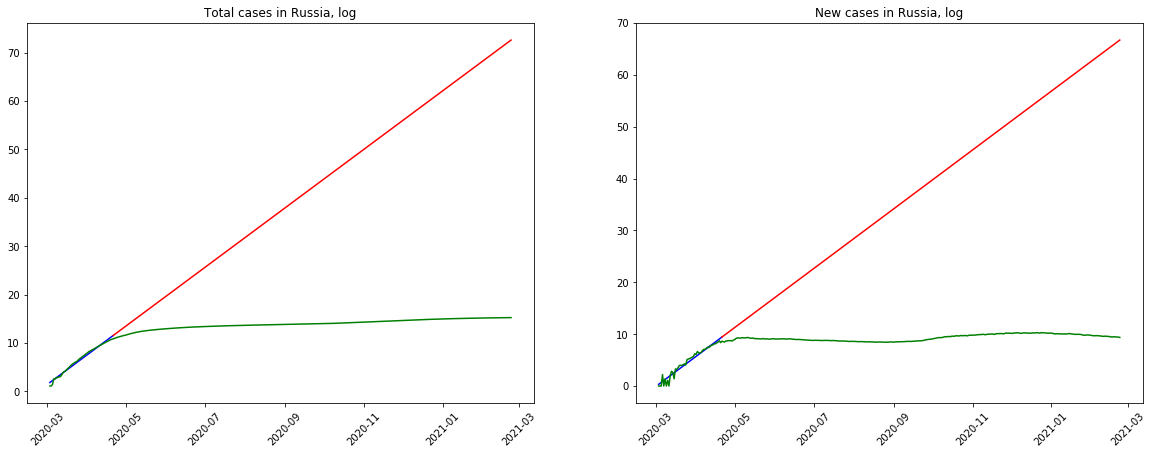

In [107]:
plt.subplots(1, 2, figsize=(20, 7))

plt.subplot(121)
plt.plot(df.iloc[:train_size].index, total_train_predict, color='blue')
plt.plot(df.iloc[train_size - 1:].index, np.hstack([[total_train_predict[-1]], total_test_predict]), color='red')
plt.plot(np.log(df.total_cases), color='green')
plt.title('Total cases in Russia, log')
plt.xticks(rotation=45)

plt.subplot(122)
plt.plot(df.iloc[:train_size].index, new_train_predict, color='blue')
plt.plot(df.iloc[train_size - 1:].index, np.hstack([[new_train_predict[-1]], new_test_predict]), color='red')
plt.plot(np.log(df.new_cases), color='green')
plt.title('New cases in Russia, log')
plt.xticks(rotation=45)

plt.show()

b) Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [108]:
def bayesian_update(mu_0, sigma_0, X, y, noise):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma_0) + noise * np.matmul(np.transpose(X), X))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma_0), np.transpose(mu_0)) + noise * np.matmul(np.transpose(X), np.array(y)))
    return mu_n, sigma_n

def aposterior(x, y, noise):
    x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
    dim = x.shape[1]
    mu_0 = np.zeros(dim)
    sigma_0 = 10 * np.eye(dim)
    
    noise_new = noise
    noise_prev = noise_new

    while True:
        mu_n, sigma_n = bayesian_update(mu_0, sigma_0, x, y, noise_new)
        predictions = np.matmul(x, mu_n)
        noise_new = 1 / np.var(y - predictions)

        if abs(noise_new - noise_prev) < 1.e-8:
            break
        else:
            noise_prev = noise_new

    return mu_n, sigma_n

In [109]:
noise = 1 / np.var(log_total_train - totalcases_exp_model.predict(x_train[:, np.newaxis]))
new_mu, new_sigma = aposterior(x_train[:, np.newaxis], log_total_train, noise)

In [110]:
new_mu, new_sigma

(array([1.62082406, 0.19833904]),
 array([[ 1.00347484e-02, -2.98061748e-04],
        [-2.98061748e-04,  1.16915441e-05]]))

c) Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

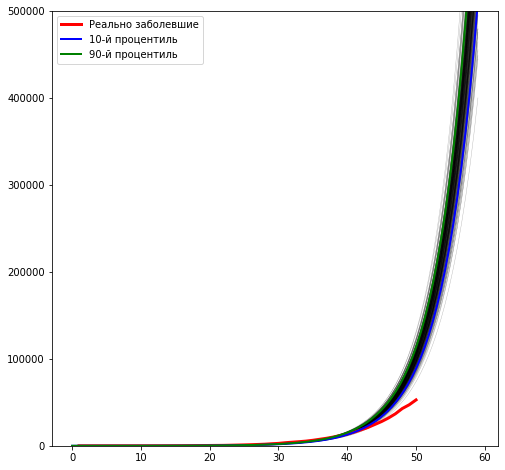

In [111]:
ws = np.random.multivariate_normal(new_mu, new_sigma, 200)
xs = np.linspace(0, 59, 100)
fig = plt.figure(figsize=(8, 8))
generated = []
for w in ws:
    generated.append(np.exp(w[0] + w[1]*xs))
    plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', linewidth=.4, alpha=.3)
    plt.ylim((0, 500000))
plt.plot(x_train, train.total_cases, 'red', linewidth=3, label = 'Реально заболевшие')
plt.plot(xs, np.percentile(np.array(generated), 10, axis=0), color='blue', linewidth=2, label='10-й процентиль')
plt.plot(xs, np.percentile(np.array(generated), 90, axis=0), color='green', linewidth=2, label='90-й процентиль')
plt.legend();

In [135]:
test = test.reset_index(drop=True)

9

In [147]:
print(f'К 1 мая модель предсказывает всего {np.exp(totalcases_exp_model.predict([[50+test[test.date==pd.Timestamp(year=2020, month=5, day=1)].index[0]]]))[0]} случаев')
print(f'К 1 июня модель предсказывает всего {np.exp(totalcases_exp_model.predict([[50+test[test.date==pd.Timestamp(year=2020, month=6, day=1)].index[0]]]))[0]} случаев')
print(f'К 1 сентября модель предсказывает всего {np.exp(totalcases_exp_model.predict([[50+test[test.date==pd.Timestamp(year=2020, month=9, day=1)].index[0]]]))[0]} случаев')

К 1 мая модель предсказывает всего 610241.5029447803 случаев
К 1 июня модель предсказывает всего 285179209.7274659 случаев
К 1 сентября модель предсказывает всего 2.386984356413661e+16 случаев


3.

In [64]:
x = np.asarray(x_train).reshape(-1, 1)
x = np.concatenate((x, x ** 2), axis=1)

train['log_new_cases'] = np.log(train.new_cases)
test['log_new_cases'] = np.log(test.new_cases)

y = train['log_new_cases']

model = LinearRegression(fit_intercept=True).fit(x, y)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


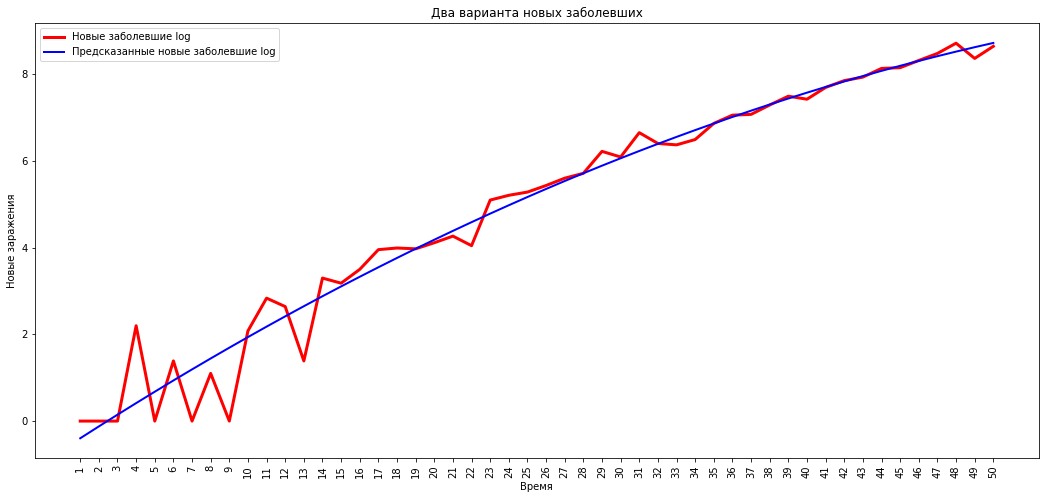

In [65]:
train['time**2'] = x_train**2
test['time**2'] = x_test**2

plt.figure(figsize=(18, 8))
plt.plot(x_train, train.log_new_cases, 'red', linewidth=3, label = 'Новые заболевшие log')
plt.plot(x_train, genius_regression_model.predict(x), 'blue', linewidth=2, label = 'Предсказанные новые заболевшие log')
plt.title('Два варианта новых заболевших')
plt.xlabel('Время')
plt.ylabel('Новые заражения')
plt.xticks(ticks=range(1,len(train)+1), rotation=90)
plt.legend()
plt.show()

In [61]:
x_ = np.arange(1,150).reshape(-1, 1)
x_ = np.concatenate((x_, x_ ** 2), axis=1)

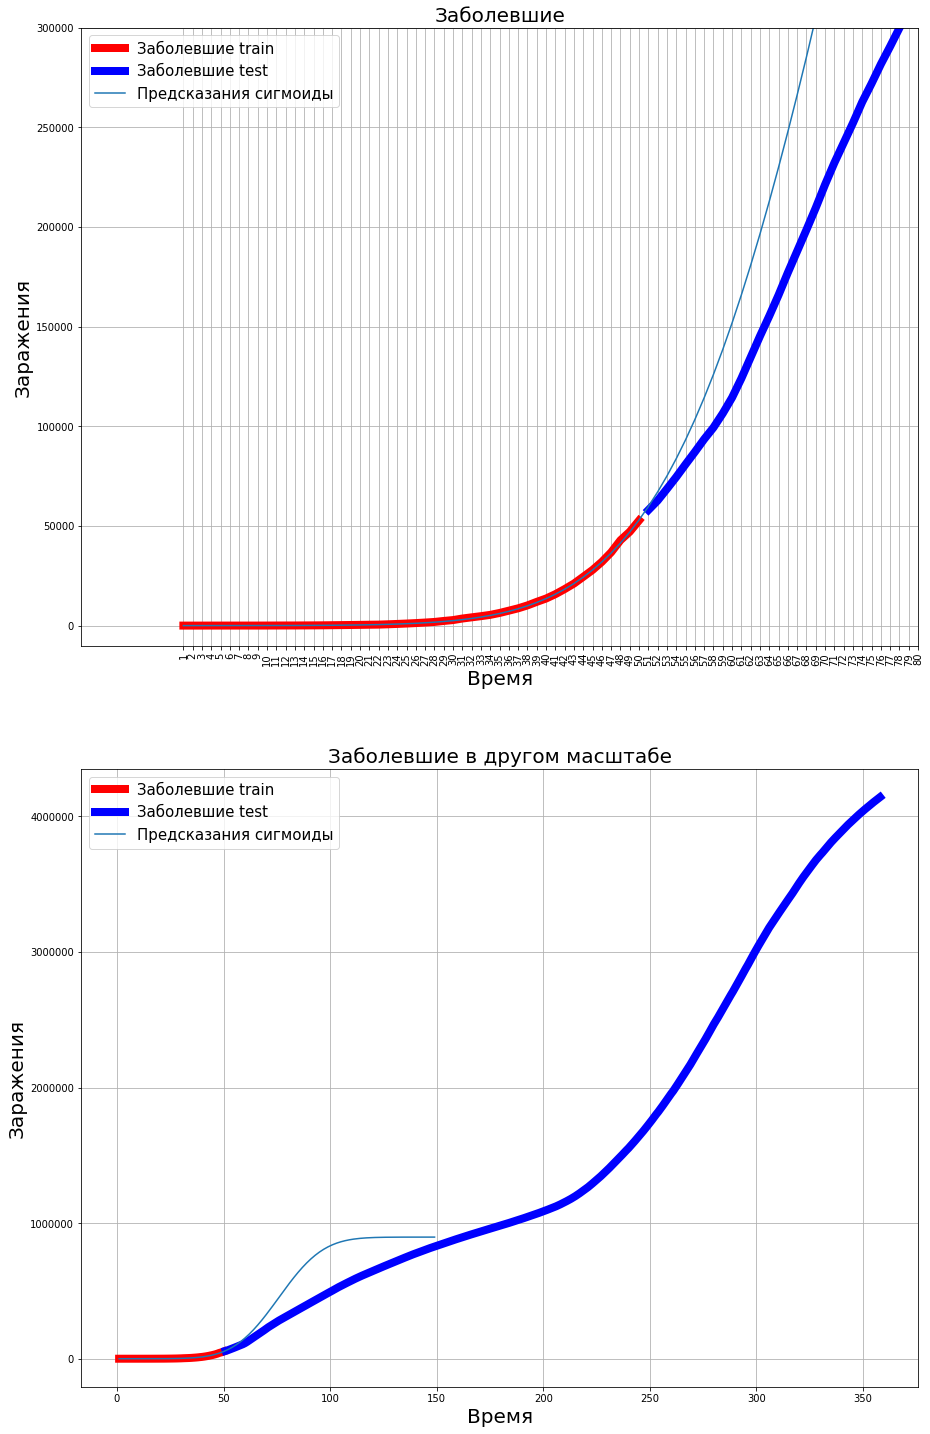

In [70]:
preds = np.exp(model.predict(x_))
preds_cumsum = np.cumsum(preds)

plt.figure(figsize=(15,25))
plt.subplot(211)
plt.title('Заболевшие', fontsize=20)
plt.xlabel('Время', fontsize=20)
plt.ylabel('Заражения', fontsize=20)
plt.plot(x_train, train.total_cases, 'red', linewidth=8, label = 'Заболевшие train')
plt.plot(x_test, test.total_cases, 'blue', linewidth=8, label = 'Заболевшие test')
plt.plot(np.arange(1,150), preds_cumsum, label = 'Предсказания сигмоиды')
plt.xticks(ticks=range(1,150), rotation=90)

plt.legend(fontsize=15)
plt.ylim(-10000,top=3e5)
plt.xlim(-10, 80)
plt.grid(True)

plt.subplot(212)
plt.title('Заболевшие в другом масштабе', fontsize=20)
plt.xlabel('Время', fontsize=20)
plt.ylabel('Заражения', fontsize=20)
plt.plot(x_train, train.total_cases, 'red', linewidth=8, label = 'Заболевшие train')
plt.plot(x_test, test.total_cases, 'blue', linewidth=8, label = 'Заболевшие test')
plt.plot(np.arange(1,150), preds_cumsum, label = 'Предсказания сигмоиды')
plt.legend(fontsize=15)
plt.grid(True)

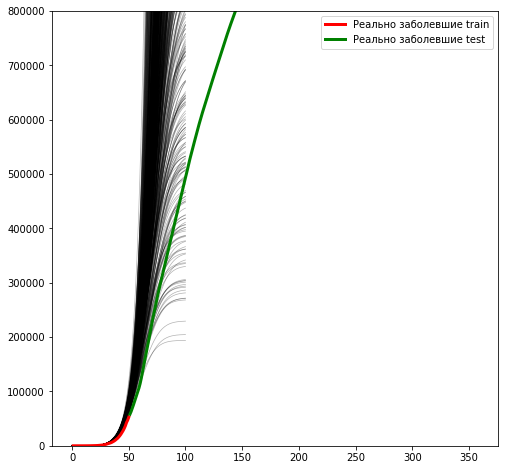

In [74]:
xs = np.linspace(0, 100, 150)
noise = 1 / np.var(y - model.predict(x))
new_mu, new_sigma = aposterior(x, y, noise)

ws = np.random.multivariate_normal(new_mu, new_sigma, 500)

preds_ = []

fig = plt.figure(figsize=(8, 8))
for w in ws:
    pred = np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))
    preds_.append(pred)
    plt.plot(xs, pred, 'k-', linewidth=.7, alpha=.3)
    plt.ylim((0, 800000))
plt.plot(x_train, train.total_cases, 'red', linewidth=3, label = 'Реально заболевшие train')
plt.plot(x_test, test.total_cases, 'green', linewidth=3, label = 'Реально заболевшие test')
plt.legend();

In [75]:
preds_ = np.array(preds_)
median_preds = np.mean(preds_, axis=0)
median_preds[::20]

array([5.21422258e-01, 1.01128041e+02, 1.98047874e+03, 2.05950061e+04,
       1.20108613e+05, 4.25259121e+05, 1.02253853e+06, 1.89937672e+06])

In [78]:
print('При пессимистичном сценарии в РФ заболеет {} человек, а при оптимистичном {}.'.format(int(np.percentile(median_preds, 90)), int(np.percentile(median_preds, 10))))

При пессимистичном сценарии в РФ заболеет 1612877 человек, а при оптимистичном 41.
